# Chronos Test

In this example, we will test Chronos on canonical geoscientific data sets chosen to be representative of geoscience/geophysics:
1. earthquake catalogs from SoCal
2. earthquake ground motion waveforms
3. near surface properties (seismic velocities, temperature, soil moisture)
4. ice velocity from greenland
5. GPS positions along a plate boundary that captures seasons and tectonic loading

The data has been prepared as CSV files with times series.
The forescasts are added to the CSV files under key attributes "Chronos-zero-shot".

Limitations by [Chronos](https://arxiv.org/pdf/2403.07815). Chronos uses large language models at its core for forecasting time series. The time series is "tokenized" to convert from an array of floats into contect tokens.


By Marine Denolle (mdenolle@uw.edu)


In [8]:
import matplotlib.pyplot as plt
import torch
from chronos import ChronosPipeline
import pandas as pd
import numpy as np

In [9]:
context_length = 128
prediction_length = 16

In [10]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

Some functions

In [154]:

def reshape_time_series(df, n_timeseries=20, duration_years=2, resample_period='D'):
    """
    Generate a list of time series from the given DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing a 'datetime' column.
    n_timeseries (int): Number of time series to generate.
    duration_years (int): Duration of each time series in years.
    resample_period (str): Resampling period (e.g., 'D' for daily).

    Returns:
    list: A list of DataFrames, each containing a time series.
    pd.DataFrame: A wide-format DataFrame containing the time series.
    """
    df_list = [pd.DataFrame() for _ in range(n_timeseries)]
    kk = 0
    while kk < n_timeseries:
        start_date = df["datetime"].sample().values[0]
        start_date = pd.to_datetime(start_date)
        
        # Create a time series for the specified duration
        end_date = start_date + pd.DateOffset(years=duration_years)
        if end_date > df["datetime"].max():
            continue    # Skip if the end date exceeds the maximum date in the catalog
        
        # Create a time series from the catalog
        time_series = df[(df["datetime"] >= start_date) & (df["datetime"] <= end_date)]
        time_series = time_series.set_index("datetime")
        time_series = time_series.resample(resample_period).mean().interpolate()
        time_series = time_series.fillna(method="ffill")
        time_series = time_series.fillna(method="bfill")
        time_series = time_series.reset_index()
        
        df_list[kk] = time_series
        kk += 1 

    df_list_count = [pd.DataFrame() for _ in range(n_timeseries)]
    for ik in range(n_timeseries):
        df_list_count[ik] = df_list[ik]["count"]
        df_list_count[ik] = df_list_count[ik].rename(f"{ik}")
    df_wide = pd.concat(df_list_count, axis=1)
    # add a first column with a date that is the same for all the 20 time series
    df_wide["datetime"] = np.arange(0, len(df_wide)) * pd.Timedelta(days=dt)
    # convert datetime to integer
    df_wide["datetime"] = df_wide["datetime"].dt.days
    # move the last column to the first position
    cols = df_wide.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df_wide = df_wide[cols]
    
    return df_list, df_wide

# Example usage:
# df_list,df_wide = reshape_time_series(df, n_timeseries=20, duration_years=2, resample_period='D')

In [161]:
def predict_chronos(df,n_timeseries=20):
    """
    Make predictions for the given time series data.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the time series data.

    Returns:
    forecast_mean (np.array): The mean forecasted values for the time series.
    lower_bound (np.array): The 5% lower bound of the forecasted values.
    upper_bound (np.array): The 95% upper bound of the forecasted values.
    mean_mae (float): The mean absolute error of the forecasted values.
    no_var_mae (float): The mean absolute error assuming no change in the time series.


    """
    # Ensure df['Date'] is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])

    # Define the percentage of data to be used for training
    alpha = 0.01  # Example: use 95% of the data for training and 5% for evaluation

    # Select the first n_timeseries columns for forecasting
    columns_to_forecast = df.columns[1:n_timeseries+1]  # +1 to skip the 'Date' column

    # Calculate the split index for training
    split_index = int(len(df) * (1 - alpha))
    print(f"Split index: {split_index}")
    print(f"Horizon: {len(df)*alpha}")

    # Split the data into training and evaluation sets for all selected columns
    train_data = df[columns_to_forecast].iloc[:split_index]
    eval_data = df[columns_to_forecast].iloc[split_index:]

    # Convert the training data to a higher-dimensional tensor
    train_tensor = torch.tensor(train_data.values, dtype=torch.float32).T

    # Perform the forecasting using the training data
    forecast = pipeline.predict(
        context=train_tensor,
        prediction_length=len(eval_data),  # Predict the same length as the evaluation set
        num_samples=50,
    )

    # Take the mean across the samples (axis=1) for each time series
    forecast_mean = forecast.mean(dim=1).squeeze().numpy()
    lower_bound = np.percentile(forecast[i, :, :].numpy(), 5, axis=0)
    upper_bound = np.percentile(forecast[i, :, :].numpy(), 95, axis=0)


    mae=[]
    # Calculate and print the MAE for each time series
    for i, column_name in enumerate(columns_to_forecast):
        # Calculate MAE for the current time series
        print(forecast_mean[i].numpy(),eval_data[column_name].values)
        mae.append (np.mean(np.abs(forecast_mean[i].numpy() - eval_data[column_name].values)))
        
        # Print the MAE
        print(f'Mean Absolute Error (MAE) for {column_name}: {mae[-1]}')

    mean_mae = np.array(mae).mean()
    print(f'Mean of forecast MAEs = {mean_mae}')

    mae_nochangemodel=[]
    # Calculate and print the MAE for each time series
    for i, column_name in enumerate(columns_to_forecast):
        # Calculate MAE for the current time series
        mae_nochangemodel.append (np.mean(np.abs(eval_data[column_name].values[-1] - eval_data[column_name].values)))
        
        # Print the MAE
        # print(f'MAE assuming d/dt=0 for {column_name}: {mae_nochangemodel[-1]}')

    no_var_mae = np.array(mae_nochangemodel).mean()
    print(f'Mean of d/dt=0 MAEs = {no_var_mae}')

    return forecast_mean, mean_mae, no_var_mae, split_index

In [ ]:
def plot_forecasts(df_wide,split_index,forecast,n_timeseries):
    """
    Plot the forecasted values along with the confidence intervals.

    Parameters:
    n_timeseries (int): Number of time series to plot.

    Returns:
    None


    """
    

    # determine the number of rows and columns for the subplots for up to 3 columns and based on the number n_timeseries
    if n_timeseries <= 3:
        nrows, ncols = 1, n_timeseries
    elif n_timeseries <= 6:
        nrows, ncols = 2, 3
    elif n_timeseries <= 9:
        nrows, ncols = 3, 3
    elif n_timeseries <= 12:
        nrows, ncols = 3, 4
    elif n_timeseries > 12:
        n_timeseries = 12 # cap the number of time series to 12



    # Select the first n_timeseries columns for forecasting
    columns_to_forecast = df_wide.columns[1:n_timeseries+1]  # +1 to skip the 'Date' column

    forecast_mean = forecast.mean(dim=1).squeeze()
    lower_bound = np.percentile(forecast, 5, axis=0)
    upper_bound = np.percentile(forecast, 95, axis=0)

    # Layout the subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 18), sharex=True)
    # Flatten the 2D array of axes for easy indexing
    axes = axes.flatten()



    # Iterate over the first n_timeseries and plot
    for i, column_name in enumerate(columns_to_forecast[0:n_timeseries]):
        # Plot the original data
        axes[i].plot(df_wide['datetime'], df_wide[column_name], label='Original Data')
        
        # Calculate the 5th and 95th percentiles for the confidence interval
        lower_bound = np.percentile(forecast[i, :, :], 5, axis=0)
        upper_bound = np.percentile(forecast[i, :, :], 95, axis=0)
        
        # Plot the forecast
        axes[i].plot(df_wide['datetime'].iloc[split_index:], forecast_mean[i], label='Forecast')
        
        # Plot the confidence intervals
        axes[i].fill_between(df_wide['datetime'].iloc[split_index:], lower_bound, upper_bound, 
                            color='r', alpha=0.2, label='95% CI')

        # Plot the evaluation data for reference
        axes[i].plot(df_wide['datetime'].iloc[split_index:], eval_data[column_name].values, '--', label='Evaluation Data')

        # Format the subplot
        axes[i].set_title(f'{column_name}, MAE={mae[i]:.2f} m/a')
        axes[i].set_ylabel('Speed (m/a)')
        axes[i].grid(True)
        axes[i].legend()

        # Apply x-tick rotation
        # axes[i].xaxis.set_major_locator(mdates.AutoDateLocator())
        # axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        axes[i].tick_params(axis='x', rotation=45)

    # Remove empty subplots if n_timeseries < 8
    for j in range(i + 1, nrows * ncols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig('dvv-forecast.png')
    plt.show()

    return

## Load data

1. Earthquake catalogs

In [155]:
# first we load data/data_qtm_catalog.csv
df = pd.read_csv("../data/data_qtm_catalog.csv")
df.head()

,datetime,count
0,2008-01-01,120
1,2008-01-02,89
2,2008-01-03,146
3,2008-01-04,166
4,2008-01-05,94


In [156]:
# calculate the time difference between each datetime to set up the dt
# convert the datetime column to datetime object
df["datetime"] = pd.to_datetime(df["datetime"])
dt = df["datetime"].diff().dt.total_seconds().fillna(0).mean()
# convert seconds to days
dt = np.ceil(dt / (60 * 60 * 24))
print(dt)

1.0


In [151]:
n_timeseries = 5

In [157]:
# randomly cut the long time series into n_timeseries, stored in data frames.
df_list,df_wide = reshape_time_series(df, n_timeseries=n_timeseries, duration_years=2, resample_period='D')

/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_24697/2872858824.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  time_series = time_series.fillna(method="ffill")
/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_24697/2872858824.py:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  time_series = time_series.fillna(method="bfill")
/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_24697/2872858824.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  time_series = time_series.fillna(method="ffill")
/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_24697/2872858824.py:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffi

In [158]:
df_wide.head()


,datetime,0,1,2,3,4
0,0,146.0,202.0,185.0,660.0,167.0
1,1,150.0,128.0,201.0,538.0,218.0
2,2,165.0,121.0,130.0,513.0,236.0
3,3,160.0,115.0,135.0,436.0,235.0
4,4,239.0,105.0,239.0,514.0,544.0


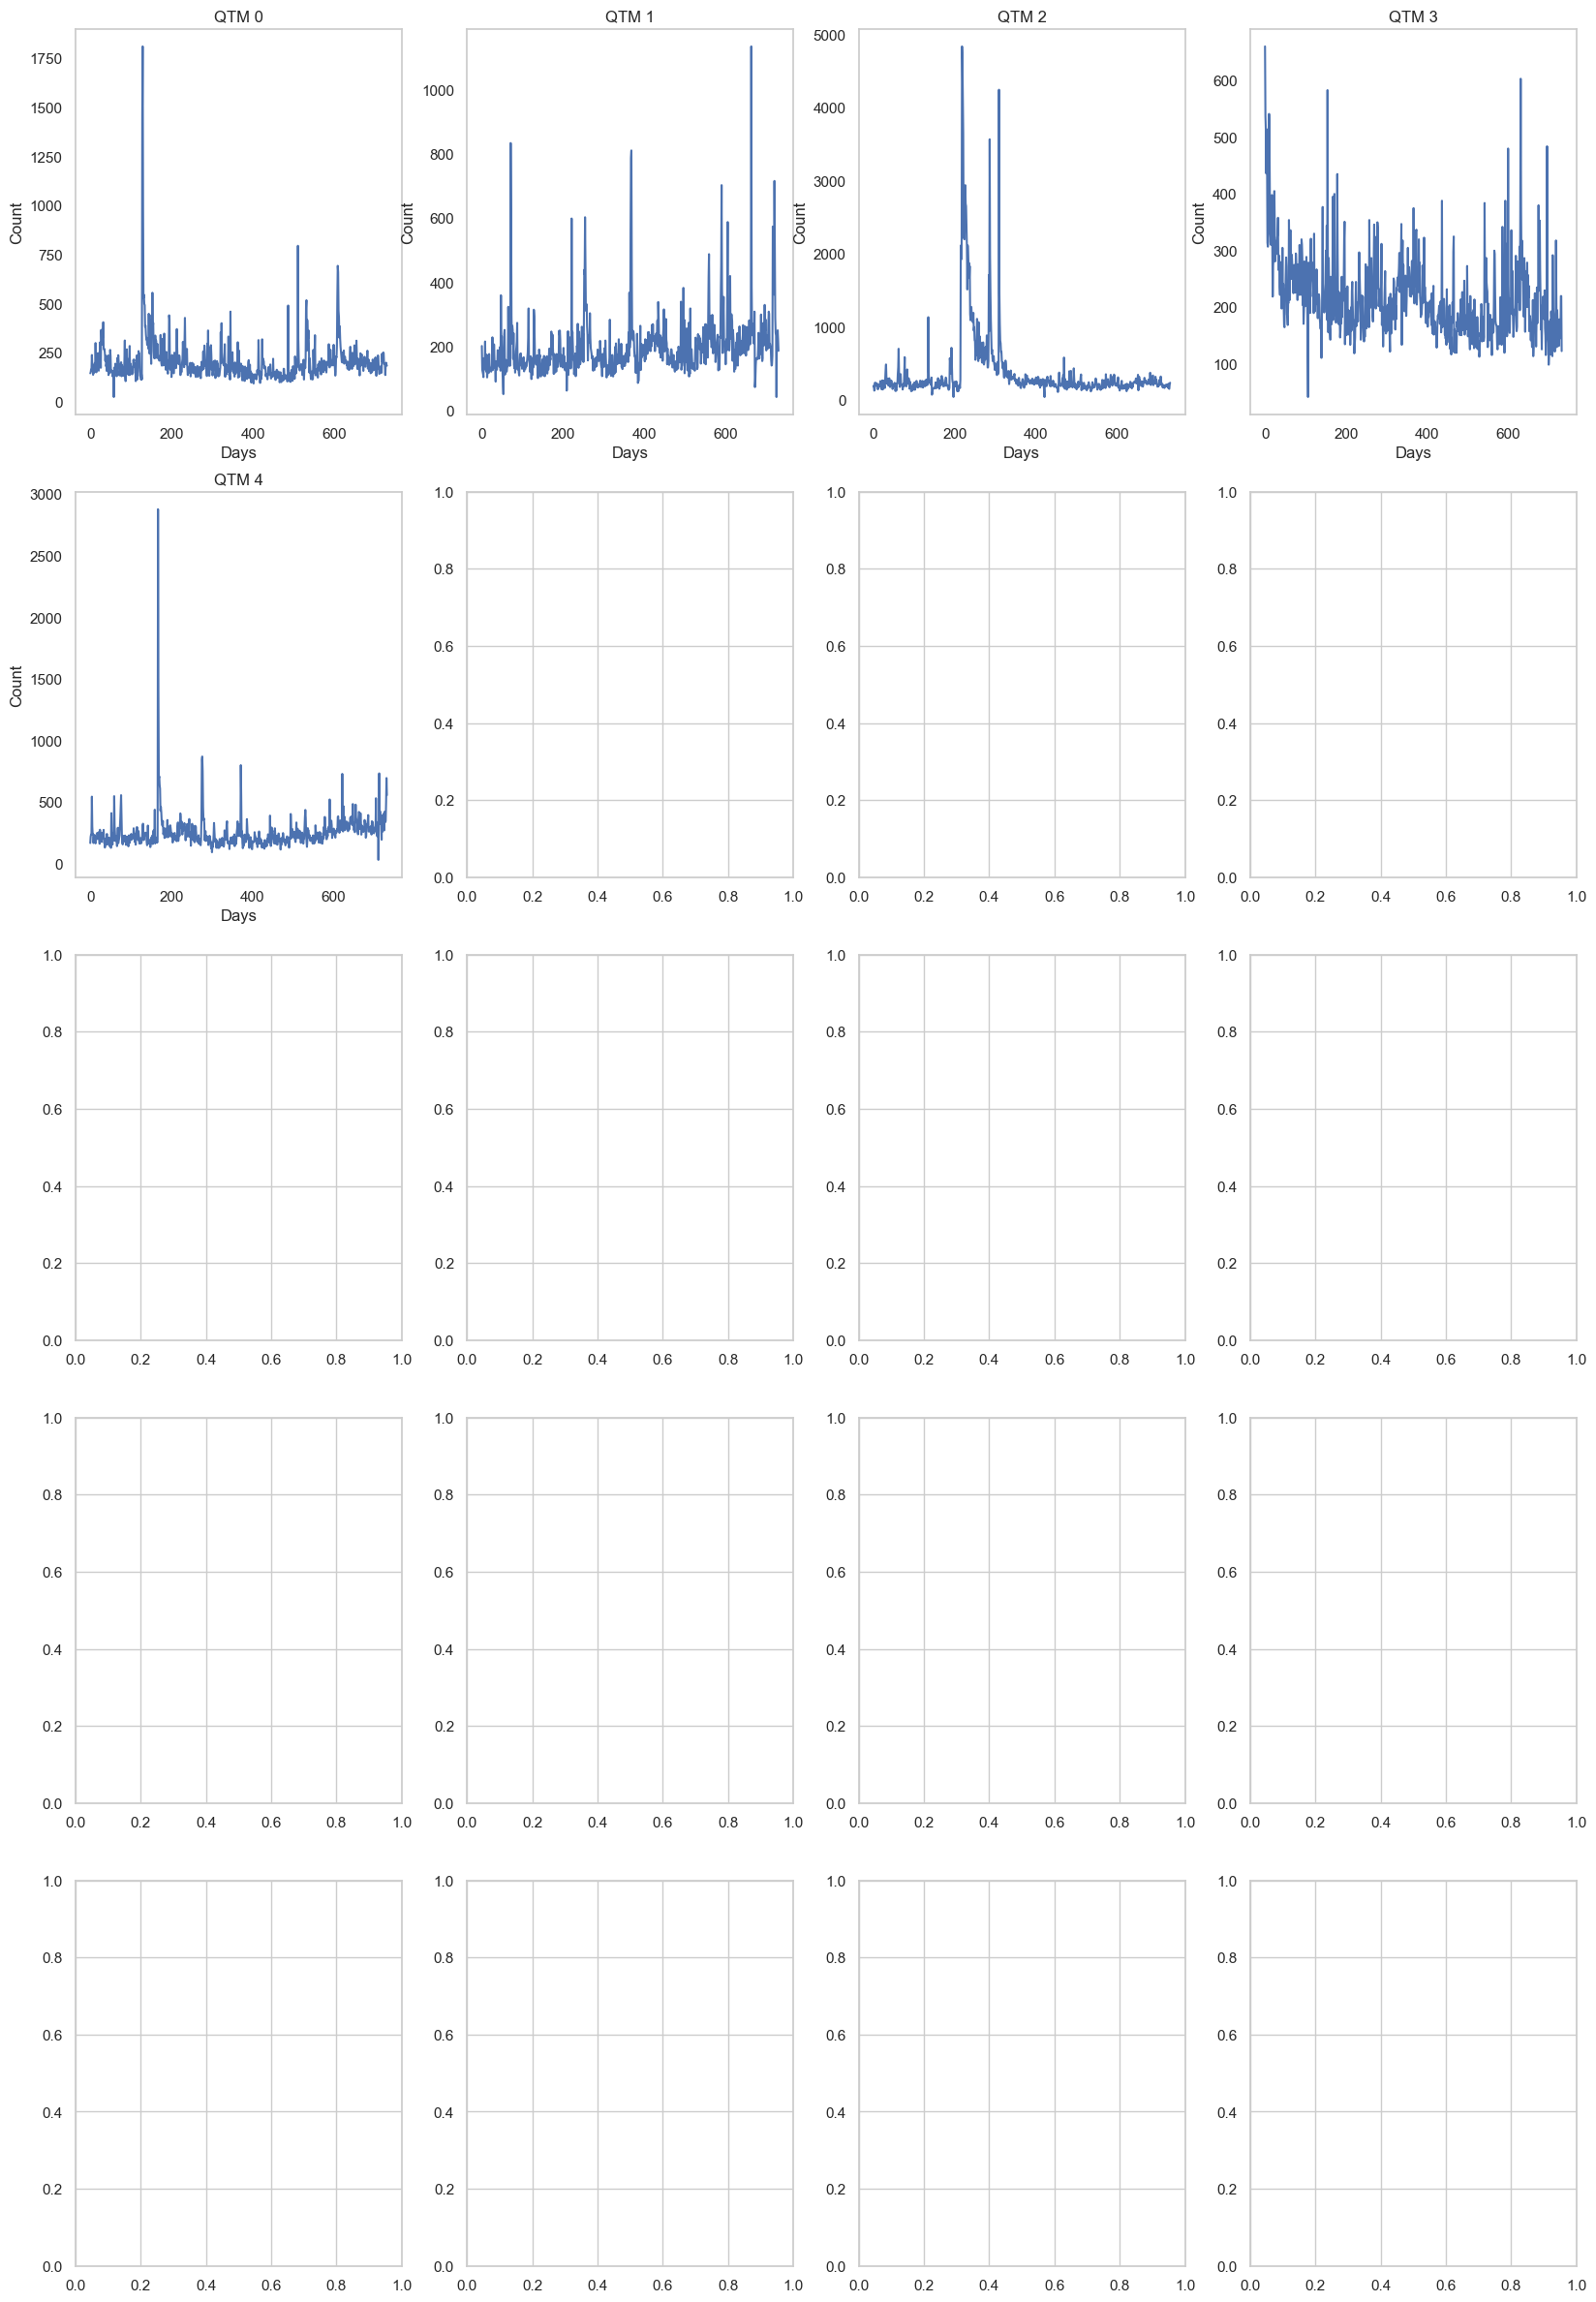

In [159]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 30))  # define the figure and subplots
axes = axes.ravel()
for i in range(n_timeseries):
    ax = axes[i]
    ax.plot(df_wide["datetime"], df_wide[f"{i}"])
    ax.set_title(f"QTM {i}")
    ax.set_xlabel("Days")
    ax.set_ylabel("Count")
    ax.grid()

## 2. Icesheet velocities

Now we test the time series of icesheet velocities in Greenland. This is work done by Brad Lipovsky.

In [ ]:

'''
Read the data
'''
df = pd.read_csv('../data/data_ice_jakobshavn.csv',na_values=[-1])


In [ ]:
# Determine the layout: 4 rows by 2 columns
nrows, ncols = 4, 3

# Create a nrows-by-ncols grid of subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 18), sharex=True)

# Flatten the 2D array of axes for easy indexing
axes = axes.flatten()

# Iterate over the first n_timeseries and plot
for i, column_name in enumerate(columns_to_forecast[0:12]):
    # Plot the original data
    axes[i].plot(df['Date'], df[column_name], label='Original Data')
    
    # Calculate the 5th and 95th percentiles for the confidence interval
    lower_bound = np.percentile(forecast[i, :, :].numpy(), 5, axis=0)
    upper_bound = np.percentile(forecast[i, :, :].numpy(), 95, axis=0)
    
    # Plot the forecast
    axes[i].plot(df['Date'].iloc[split_index:], forecast_mean[i].numpy(), label='Forecast')
    
    # Plot the confidence intervals
    axes[i].fill_between(df['Date'].iloc[split_index:], lower_bound, upper_bound, 
                         color='r', alpha=0.2, label='95% CI')

    # Plot the evaluation data for reference
    axes[i].plot(df['Date'].iloc[split_index:], eval_data[column_name].values, '--', label='Evaluation Data')

    # Format the subplot
    axes[i].set_title(f'{column_name}, MAE={mae[i]:.2f} m/a')
    axes[i].set_ylabel('Speed (m/a)')
    axes[i].grid(True)
    axes[i].legend()

    # Apply x-tick rotation
    axes[i].xaxis.set_major_locator(mdates.AutoDateLocator())
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[i].tick_params(axis='x', rotation=45)

# Remove empty subplots if n_timeseries < 8
for j in range(i + 1, nrows * ncols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('jakobshavn-forecast.png')
plt.show()

## 3. Forecasting GPS velocities

In this case, we are going to test Chrono's performance on GPS time series. Vertical components tend to exhibit seasonal loading from precipitation, horizontal components tend to exhibit tectonic processes, especially at plate boundaries.

In [113]:
# read data from data_gps_P395_relateive_position.csv
df = pd.read_csv("../data/data_gps_P395_relative_position.csv")
# convert dacimal year column to floats
df["decimal year"] = df["decimal year"].astype(float)
df.head()
# the date format is in decimal years, convert it to datetime
# df["datetime"] = pd.to_datetime(df["decimal year"], format="%Y.%j")
# df.head()

,decimal year,new delta e (m),new delta n (m),new delta v (m)
0,2006.0671,0.00000,0.00000,0.00000
1,2006.0698,0.00169,-0.00067,-0.00675
2,2006.0726,0.00155,0.00101,0.00228
3,2006.0753,0.00021,-0.00150,0.00704
4,2006.0780,0.00125,-0.00162,-0.00165


In [116]:
.0698*365

25.477

## 4. Forecast dv/v

In [118]:
# read one dv/v file
df = pd.read_csv("../data/DVV_data_withMean/Data_BGU.csv")
df.head()

,date,dv,temp,sm_ewt,lp_lake,lake
0,2007-02-03,-0.1144,-1.9490,0.4645,0.2920,1370.9875
1,2007-02-04,-0.1211,-1.9249,0.4647,0.2930,1370.9906
2,2007-02-05,-0.1260,-1.8253,0.4648,0.2939,1370.9936
3,2007-02-06,-0.1276,-1.5767,0.4649,0.2949,1370.9969
4,2007-02-07,-0.1357,-1.3691,0.4651,0.2958,1371.0000


In [129]:
# convert the date into a timestamp
df["datetime"] = pd.to_datetime(df["date"])
df["timestamp"]=df["date"].values.astype(np.int64) // 10 ** 9

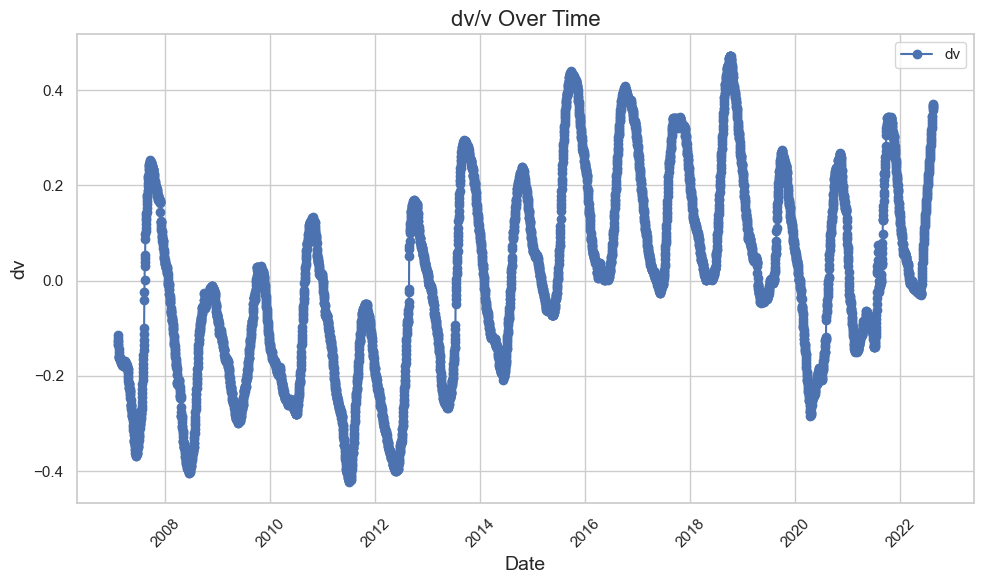

In [130]:
!pip install seaborn
import seaborn as sns

# Set the style of the plot
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(df["date"], df["dv"], marker='o', linestyle='-', color='b', label='dv')

# Add labels and title
plt.xlabel("Date", fontsize=14)
plt.ylabel("dv", fontsize=14)
plt.title("dv/v Over Time", fontsize=16)

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [131]:
# now break the data into 2 years and make 20 examples of 2-year time series
# select a random start date from the data frame to generate a 2-year time series from the catalog. Make 20 examples of 2-year time series.
# we will make a list of 20 dictionaries, each dictionary will have a start date and a time series
# initialize a list of 20 dictionaries
df_list = [pd.DataFrame() for _ in range(n_timeseries)]
for ik in range(n_timeseries):
    start_date = df["datetime"].sample().values[0]
    start_date = pd.to_datetime(start_date)
    print(start_date)
    # create a time series for the next 2 years
    end_date = start_date + pd.DateOffset(years=2)
    # create a time series from the catalog
    time_series = df[(df["datetime"] >= start_date) & (df["datetime"] <= end_date)]
    time_series = time_series.set_index("datetime")
    time_series = time_series.resample(f"{dt}D").mean().interpolate()
    time_series = time_series.fillna(method="ffill")
    time_series = time_series.fillna(method="bfill")
    time_series = time_series.reset_index()
    df_list[ik] = time_series


2010-11-03 00:00:00
2020-01-31 00:00:00
2020-10-31 00:00:00
2019-04-21 00:00:00
2007-07-02 00:00:00
2021-02-02 00:00:00
2022-03-26 00:00:00
2007-10-19 00:00:00
2009-03-03 00:00:00
2012-12-24 00:00:00
2015-08-29 00:00:00
2022-04-26 00:00:00
2021-09-22 00:00:00
2018-08-26 00:00:00
2018-02-16 00:00:00
2007-07-05 00:00:00
2018-04-09 00:00:00
2008-06-24 00:00:00
2019-12-15 00:00:00
2019-07-05 00:00:00


/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_24697/1520319028.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  time_series = time_series.fillna(method="ffill")
/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_24697/1520319028.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  time_series = time_series.fillna(method="bfill")
/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_24697/1520319028.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  time_series = time_series.fillna(method="ffill")
/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_24697/1520319028.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffi

In [133]:
# take each "count" column from the 20 dataframes and assemble a single wide dataframe ith all the columns
# initialize a list of 20 dataframes
df_list_count = [pd.DataFrame() for _ in range(n_timeseries)]
for ik in range(n_timeseries):
    df_list_count[ik] = df_list[ik]["dv"]
    df_list_count[ik] = df_list_count[ik].rename(f"{ik}")
df_wide = pd.concat(df_list_count, axis=1)
# add a first column with a date that is the same for all the 20 time series
df_wide["datetime"] = np.arange(0, len(df_wide)) * pd.Timedelta(days=dt)
# convert datetime to integer
df_wide["datetime"] = df_wide["datetime"].dt.days
# move the last column to the first position
cols = df_wide.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_wide = df_wide[cols]
df_wide.head()


,datetime,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,0,0.1200,-0.0008,0.2537,-0.0219,-0.3237,-0.0985,-0.0103,0.2066,-0.1682,...,0.3933,-0.0232,0.2816,0.3942,0.1042,-0.3091,0.0119,-0.3918,0.0875,-0.0089
1,1,0.1233,-0.0042,0.2571,-0.0252,-0.3205,-0.1004,-0.0138,0.2050,-0.1682,...,0.3932,-0.0215,0.3065,0.3941,0.1026,-0.3039,0.0103,-0.3901,0.0858,-0.0057
2,2,0.1217,-0.0076,0.2571,-0.0251,-0.3139,-0.1022,-0.0138,0.2017,-0.1649,...,0.3980,-0.0215,0.3140,0.4025,0.1010,-0.3022,0.0103,-0.3866,0.0809,-0.0027
3,3,0.1150,-0.0109,0.2604,-0.0233,-0.3091,-0.1035,-0.0155,0.2017,-0.1683,...,0.4030,-0.0232,0.3195,0.4073,0.0993,-0.3006,0.0103,-0.3867,0.0826,-0.0027
4,4,0.1100,-0.0142,0.2652,-0.0267,-0.3039,-0.1077,-0.0121,0.2001,-0.1717,...,0.4064,-0.0249,0.3233,0.4105,0.0993,-0.2990,0.0086,-0.3818,0.0826,-0.0027


In [134]:
# generate batch predictions
# 
# # Define the percentage of data to be used for training
alpha = 0.05  # Example: use 95% of the data for context (= training) and 5% for prediction ( = evaluation) 

# Select the first n_timeseries columns for forecasting
columns_to_forecast = df_wide.columns[1:n_timeseries+1]  # +1 to skip the 'Date' column

# Calculate the split index for training
split_index = int(len(df_wide) * (1 - alpha))

# Split the data into training and evaluation sets for all selected columns
train_data = df_wide[columns_to_forecast].iloc[:split_index]
eval_data = df_wide[columns_to_forecast].iloc[split_index:]
print(train_data.shape, eval_data.shape)
# Convert the training data to a higher-dimensional tensor
train_tensor = torch.tensor(train_data.values, dtype=torch.float32).T

# Perform the forecasting using the training data
forecast = pipeline.predict(
    context=train_tensor,
    prediction_length=len(eval_data),  # Predict the same length as the evaluation set
    num_samples=50,
)

# Take the mean across the samples (axis=1) for each time series
forecast_mean = forecast.mean(dim=1).squeeze()


(695, 20) (37, 20)


In [135]:
mae=[]
# Calculate and print the MAE for each time series
for i, column_name in enumerate(columns_to_forecast):
    # Calculate MAE for the current time series
    mae.append (np.mean(np.abs(forecast_mean[i].numpy() - eval_data[column_name].values)))
    
    # Print the MAE
    # print(f'Mean Absolute Error (MAE) for {column_name}: {mae[-1]}')

print(f'Mean of forecast MAEs = {np.array(mae).mean()}')

mae_nochangemodel=[]
# Calculate and print the MAE for each time series
for i, column_name in enumerate(columns_to_forecast):
    # Calculate MAE for the current time series
    mae_nochangemodel.append (np.mean(np.abs(eval_data[column_name].values[-1] - eval_data[column_name].values)))
    
    # Print the MAE
    # print(f'MAE assuming d/dt=0 for {column_name}: {mae_nochangemodel[-1]}')

print(f'Mean of d/dt=0 MAEs = {np.array(mae_nochangemodel).mean()}')

Mean of forecast MAEs = nan
Mean of d/dt=0 MAEs = nan


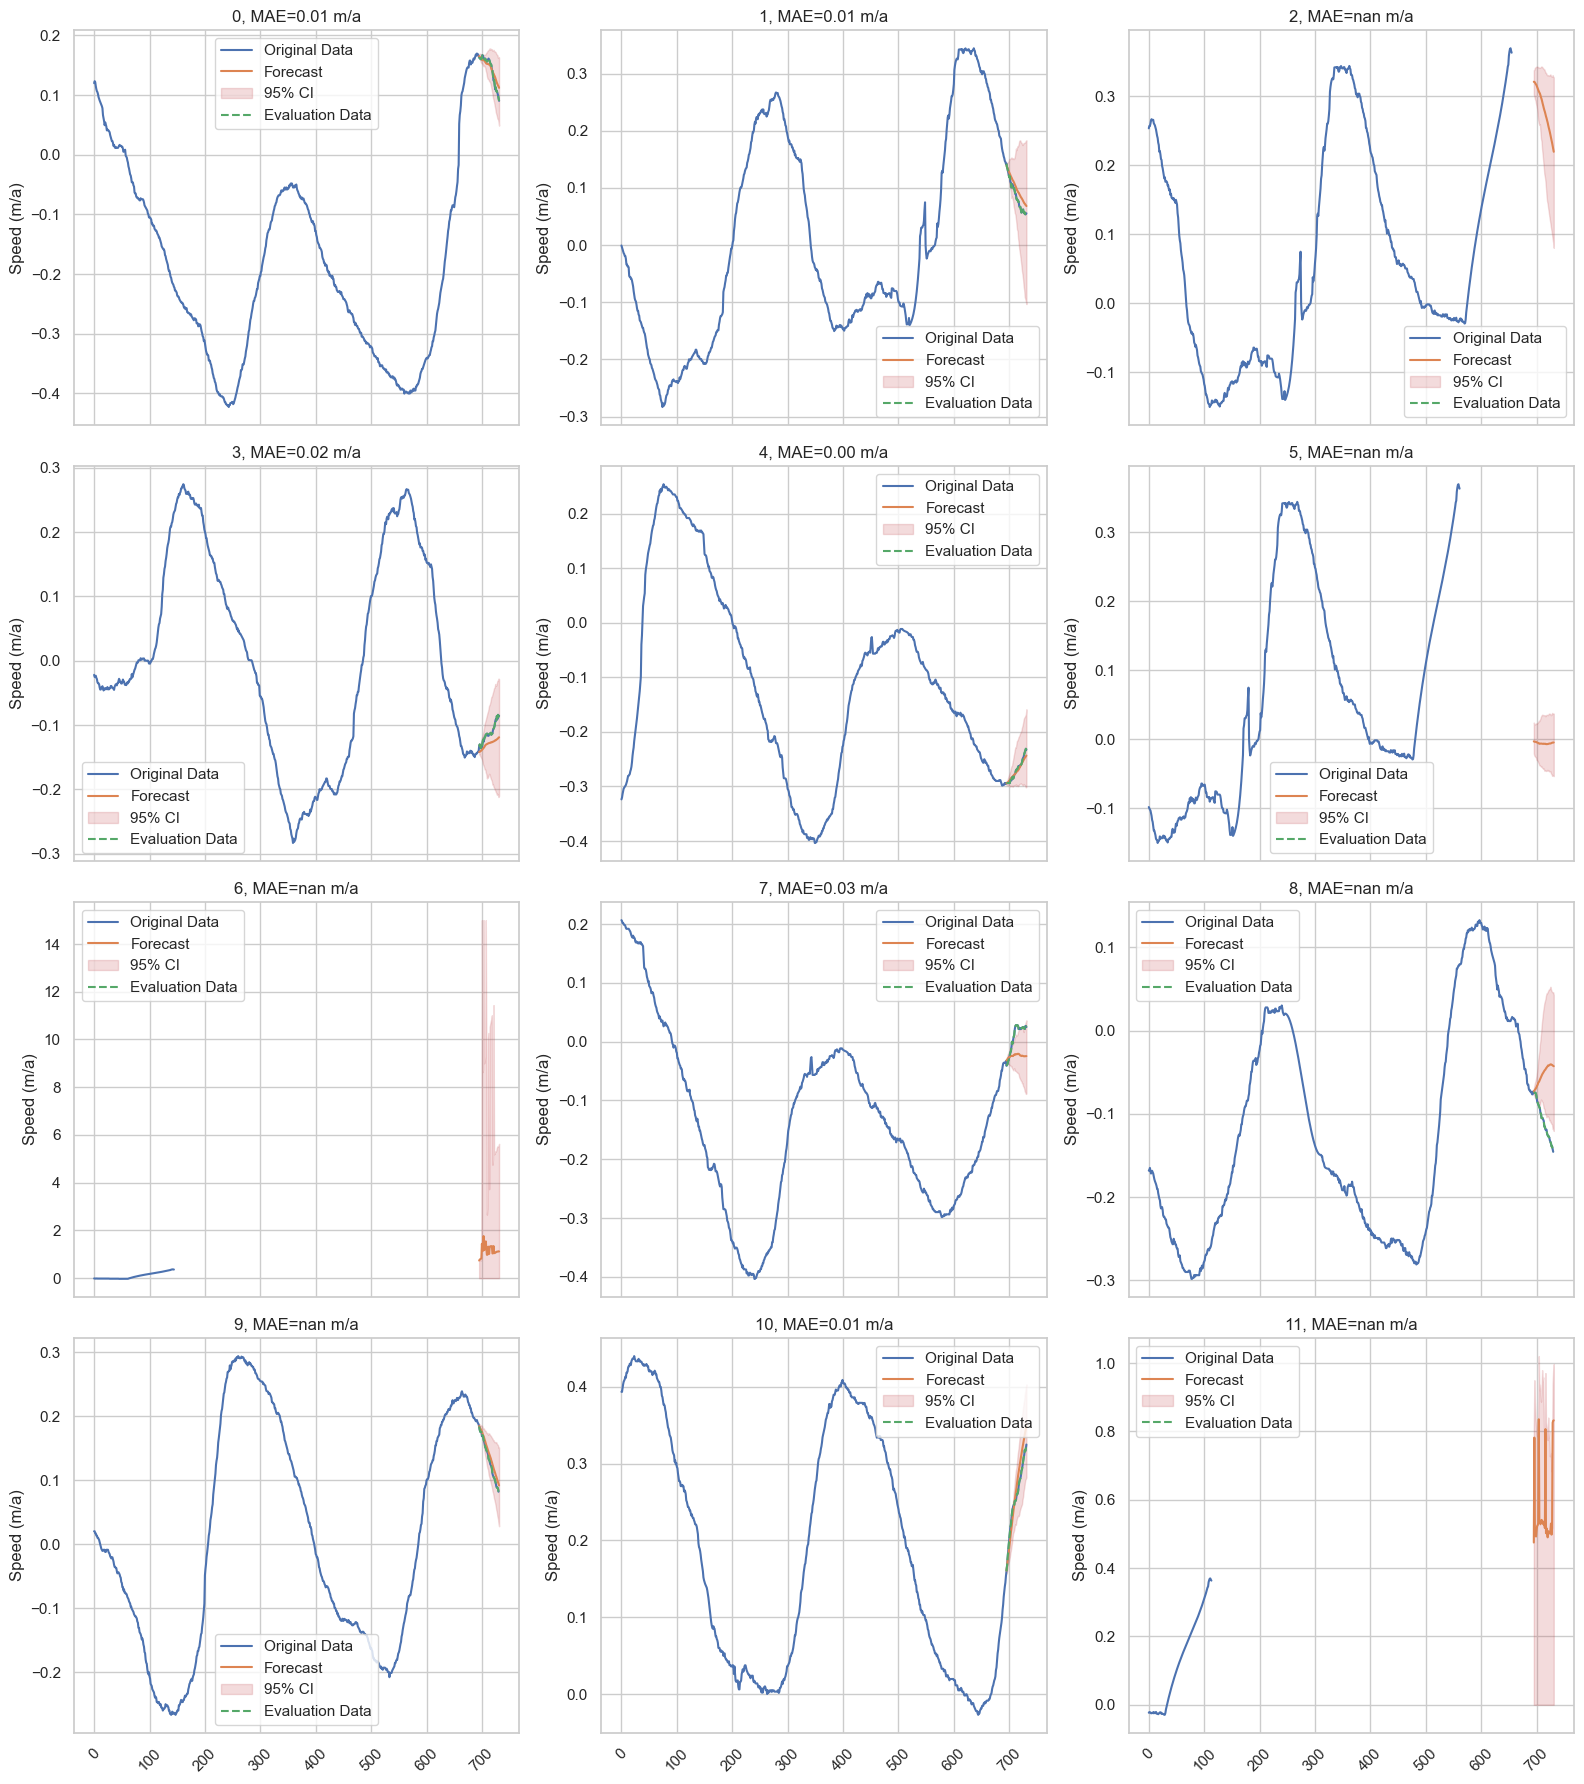

In [146]:
# Determine the layout: 4 rows by 2 columns
nrows, ncols = 4, 3

# Create a nrows-by-ncols grid of subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 18), sharex=True)

# Flatten the 2D array of axes for easy indexing
axes = axes.flatten()

# Iterate over the first n_timeseries and plot
for i, column_name in enumerate(columns_to_forecast[0:12]):
    # Plot the original data
    axes[i].plot(df_wide['datetime'], df_wide[column_name], label='Original Data')
    
    # Calculate the 5th and 95th percentiles for the confidence interval
    lower_bound = np.percentile(forecast[i, :, :].numpy(), 5, axis=0)
    upper_bound = np.percentile(forecast[i, :, :].numpy(), 95, axis=0)
    
    # Plot the forecast
    axes[i].plot(df_wide['datetime'].iloc[split_index:], forecast_mean[i].numpy(), label='Forecast')
    
    # Plot the confidence intervals
    axes[i].fill_between(df_wide['datetime'].iloc[split_index:], lower_bound, upper_bound, 
                         color='r', alpha=0.2, label='95% CI')

    # Plot the evaluation data for reference
    axes[i].plot(df_wide['datetime'].iloc[split_index:], eval_data[column_name].values, '--', label='Evaluation Data')

    # Format the subplot
    axes[i].set_title(f'{column_name}, MAE={mae[i]:.2f} m/a')
    axes[i].set_ylabel('Speed (m/a)')
    axes[i].grid(True)
    axes[i].legend()

    # Apply x-tick rotation
    # axes[i].xaxis.set_major_locator(mdates.AutoDateLocator())
    # axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[i].tick_params(axis='x', rotation=45)

# Remove empty subplots if n_timeseries < 8
for j in range(i + 1, nrows * ncols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('dvv-forecast.png')
plt.show()